# Metaplectic Geometrical Optics in 3D - Tracing Rays and Calculating Amplitude

## MGO Solution to Airy Problem

### Setup

In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

from scipy.integrate import cumulative_trapezoid
from scipy.special import airy
from scipy.signal import find_peaks
from itertools import product

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
from skimage.segmentation import flood

def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

def np_eye(shape):
    eye = np.zeros(shape)
    eye[..., :, :] = np.eye(shape[-1])
    return eye

def np_diag(v):
    eye = np_eye((*v.shape, v.shape[-1]))
    return eye * np.stack([v]*v.shape[-1], axis=-1)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a, ND = 3):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0) * ND
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

In [4]:
@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

### Exact Solution gives Initial Conditions

In [5]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-8, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

In [6]:
x0, phi0

(-7.375375375375375, 0.3422883374530224)

### Ray Tracing

In [7]:
ND = 3
nt, n2, n3 = 100, 10, 10

y0s = np.linspace(0, 1, n2)
z0s = np.linspace(0, 10, n3)

rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]
zs = np.concatenate([rs, ks], axis=-1)

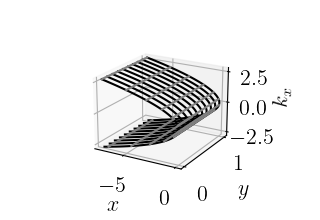

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(projection='3d')
for i, y0 in enumerate(y0s):
    ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$k_x$')
for i in range(0, len(t), int(len(t)/10)):
    ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
ax.view_init(20, -60, 0)
plt.tight_layout()
plt.savefig('./plots/3D_MGO_airy_dispersion_manifold.png')
plt.savefig('./plots/3D_MGO_airy_dispersion_manifold.pdf')
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

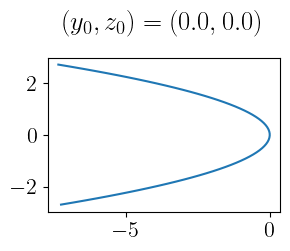

In [9]:
i, j = (0, 0)
plt.figure(figsize=(3,2))
plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0])
plt.title(r'$(y_0, z_0) = (' + str(round(y0s[i], 2)) + ', ' + str(round(z0s[j], 2)) + ')$')
plt.show()

### MGO Part

**Note**: In this numerical implementation, the vector quantities $r$, $k$ (the variables `rs`, `ks` in the code) are written as squeezed row vectors such that they have 3 as their last dimension, and $z=(r, k)$ (the variable `zs` in the code) has 6 as its' last dimension. Thus, the last axis is transposed when compared to Lopez' derivations. However, for convenience, I've chosen to write all matrices from the Lopez-article with the usual shaping. I.e: I have chosen **not** to transpose the matrices. For instance, each *column* in $S^{-1}$ corresponds to either a tangent or normal vector of the dispersion manifold.

In [10]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

def get_symplectic_tangent_trfm(zs, ND):
    gradt_z = fd.grad(zs, t)
    norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
    T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

    # For each tau, create an identity matrix
    eye = np_eye((*zs.shape, zs.shape[-1]))
    
    # For each tau, create orthonormal basis starting from
    # single tangent vector using Gram Schmidt orthogonalization
    ONB = np.copy(eye)
    ONB[..., 0] = T1
    ONB = gram_schmidt_orthogonalize(ONB)

    # Tangent space is first 3 vectors of basis:
    # Note: Basis vectors in T are shaped as columns!
    T = ONB[..., :ND]

    symplJ = np.zeros_like(ONB)
    symplJ[..., :, :] =  np.block([
        [  np.zeros((ND, ND)),  np.eye((ND))        ],
        [  -np.eye(ND),         np.zeros((ND, ND))  ]])
    
    N = -np.matmul(symplJ, T)
    R = np.concatenate((T, N), axis=-1)
    S = np_transpose(R)
    return S

In [11]:
S = get_symplectic_tangent_trfm(zs, ND)
A, B = S[..., :ND, :ND], S[..., :ND, ND:]
gradtau_z = fd.grad(zs, t, y0s, z0s)
Q = np.block([[np_transpose(A)], [np_transpose(B)]])
R = np_transpose(Q) @ gradtau_z

In [12]:
Us, lambs, Vs = np.linalg.svd(B)
Lambdas = np_diag(lambs)
ranks = np.linalg.matrix_rank(B)

eyes = np_eye(A.shape)
eye_rhos = np.copy(eyes)
for i in range(A.shape[-1]):
    eye_rhos[ranks == i, i:, i:] = 0
eye_zetas = eyes - eye_rhos
A_tilde = np_transpose(Us) @ A @ Vs
A_zetas = (np_transpose(eye_zetas) @ A_tilde @ eye_zetas) + eye_rhos
A_rhos = (np_transpose(eye_rhos) @ A_tilde @ eye_rhos) + eye_zetas
Lambda_rhos = (np_transpose(eye_rhos) @ Lambdas @ eye_rhos) + eye_zetas

Nt = (phi0 * np.emath.sqrt(fd.grad(rs[:3, ..., 0], t)[0, ...])
    * np.exp(1j * ( cumulative_trapezoid(np_inner_product(fd.grad(rs, t), ks), t, initial=0, axis=0) ))
    ) / (
    np.emath.power((- 1j * 2*np.pi), (ranks/2)) * (
        np.emath.sqrt(
            np.linalg.det(Lambda_rhos) * np.linalg.det(A_zetas) * np.linalg.det(R)
        )
    )
)

#### Digression: Inspection of Tangent and Normal Vectors and prefactor

In [13]:
print(
    'Check that S has orthosymplectic shape [[A, B], [-B, A]]',
    np.all(np.isclose(S[..., :ND, :ND] - S[..., ND:, ND:], 0)),
    np.all(np.isclose(S[..., :ND, ND:] + S[..., ND:, :ND], 0)),
)

Check that S has orthosymplectic shape [[A, B], [-B, A]] True True


In [14]:
# # Alternatively with QR Decomposition
# # It appears that this give rise to a sign error - we are not guarenteed that the tangent vector points in the right direction
# gradtau_z = fd.grad(zs, t, y0s, z0s)
# gradtau_x = gradtau_z[..., :ND, :]
# Q, R = np.linalg.qr(gradtau_z)
# A = np_transpose(Q[..., :ND, :])
# B = np_transpose(Q[..., ND:, :])
# S = np.block([[A, B], [-B, A]])

# # import scipy
# # Q0, R0 = scipy.linalg.qr(gradtau_z[0, 0, 0], mode='economic')

# # # Create Symplectic Matrix (J)
# # symplJ = np.zeros_like(S)
# # symplJ[..., :, :] =  np.block([
# #     [  np.zeros((ND, ND)),  np.eye((ND))        ],
# #     [  -np.eye(ND),         np.zeros((ND, ND))  ]])

# # print(
# #     'check that I understood np block correctly:',
# #     'S shape:', S.shape,
# #     np.all(np.isclose(S[:, 0, 0, :ND, :ND] - A[:, 0, 0], 0)),
# #     np.all(np.isclose(S[:, 0, 0, :ND, ND:] - B[:, 0, 0], 0)),
# #     np.all(np.isclose(S[:, 0, 0, ND:, :ND] + B[:, 0, 0], 0)),
# #     np.all(np.isclose(S[:, 0, 0, ND:, ND:] - A[:, 0, 0], 0))
# # )

# # T = np_transpose(S)[:, 0, 0, slice(0, 2*ND, ND), 0]
# # N = np_transpose(S)[:, 0, 0, slice(0, 2*ND, ND), ND]

# # print(
# #     'sample tests of matrices',
# #     '\n\n T^T T \n',
# #     np_inner_product(T, T)[:3],
# #     '\n\n N^T N \n',
# #     np_inner_product(N, N)[:3],
# #     '\n\n N^T J T \n',
# #     np.matmul(np_transpose(N[..., np.newaxis]), np.matmul(np.array([[0, 1], [-1, 0]]), T[..., np.newaxis]))[:3],
# #     '\n\n T^T J T \n',
# #     np.matmul(np_transpose(T[..., np.newaxis]), np.matmul(np.array([[0, 1], [-1, 0]]), T[..., np.newaxis]))[:3]
# # )

In [15]:
T = np_transpose(S)[..., :ND]
N = np_transpose(S)[..., ND:]

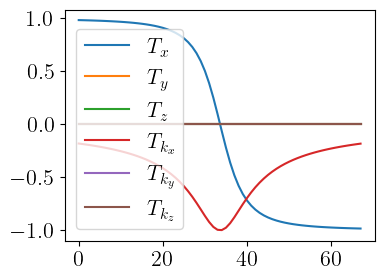

In [16]:
plt.figure(figsize=(4,3))
plt.plot(T[:, 0, 0, :, 0])
plt.legend([r'$T_{x}$', r'$T_{y}$', r'$T_{z}$', r'$T_{k_x}$', r'$T_{k_y}$', r'$T_{k_z}$'])
plt.show()

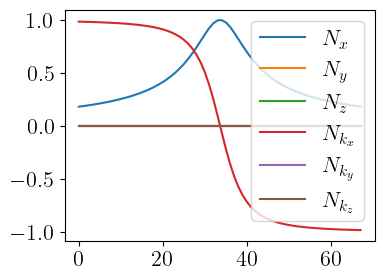

In [17]:
plt.figure(figsize=(4,3))
plt.plot(N[:, 0, 0, :, 0])
plt.legend([r'$N_{x}$', r'$N_{y}$', r'$N_{z}$', r'$N_{k_x}$', r'$N_{k_y}$', r'$N_{k_z}$'])
plt.show()

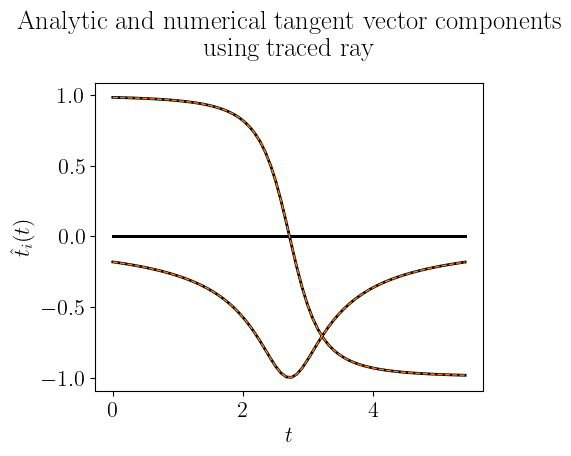

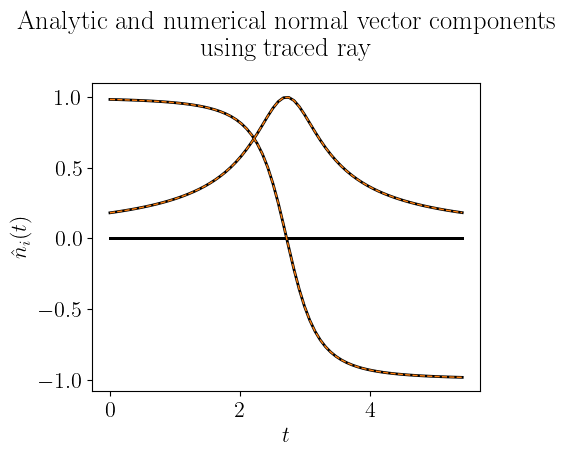

In [18]:
v_ex = np.sqrt(1+4*(ks[..., 0]**2))
T_ex = np.stack([ 1/v_ex * 2*ks[..., 0], -1/v_ex * np.ones_like(ks[..., 0])], axis=-1) # tangent matrix from Lopez example
N_ex = np.stack([ 1/v_ex * np.ones_like(ks[..., 0]), 1/v_ex * 2*ks[..., 0] ], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using traced ray')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using traced ray')
plt.show()

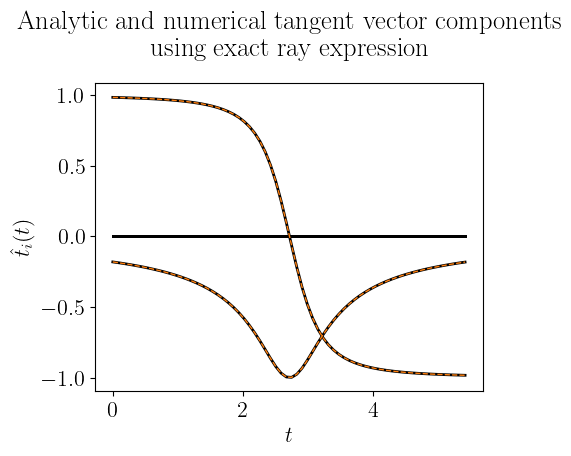

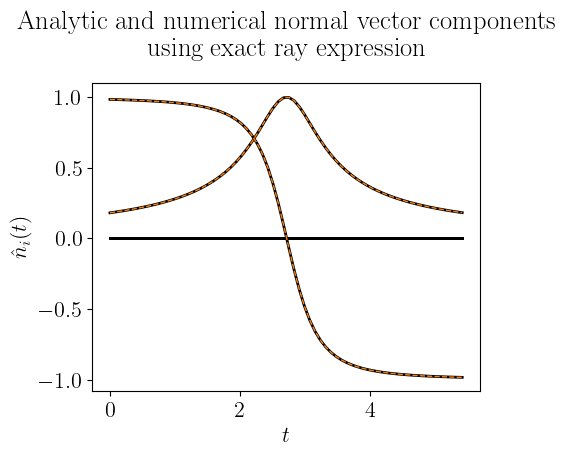

In [19]:
ks_ex = np.apply_along_axis(lambda x: x - t, axis=0, arr=np.ones_like(ks[..., 0]) * ks[0, ..., 0])
v_exx = np.sqrt(1+4*(ks_ex**2))
T_exx = np.stack([ 1/v_ex * 2*ks_ex, -1/v_ex * np.ones_like(ks_ex)], axis=-1) # tangent matrix from Lopez example
N_exx = np.stack([ 1/v_ex * np.ones_like(ks_ex), 1/v_ex * 2*ks_ex], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using exact ray expression')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using exact ray expression')
plt.show()

In [20]:
# from matplotlib import animation

# fig = plt.figure(figsize=(5,4))
# plt.axis('equal')
# plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0], 'k-')
# plt.xlim(np.min(rs[:, 0, 0, 0]), 0)
# # plt.xlim(-6, 0)
# plt.ylim(-3, 3)
# plt.grid()
# plt.xlabel(r'$x$')
# plt.ylabel(r'$k$')

# t_param = np.linspace(0, 10, 2)

# tangent = plt.plot(rs[0, 0, 0, 0] + T[0, 0, 0, 0, 0] * t_param, ks[0, 0, 0, 0] + T[0, 0, 0, ND, 0] * t_param, '--', color='red')[0]
# normal = plt.plot(rs[0, 0, 0, 0] + N[0, 0, 0, 0, 0] * t_param, ks[0, 0, 0, 0] + N[0, 0, 0, ND, 0] * t_param, '--', color='blue')[0]

# def update(frame):
#     tangent.set_xdata(rs[frame, 0, 0, 0] + T[frame, 0, 0, 0, 0] * t_param)
#     tangent.set_ydata(ks[frame, 0, 0, 0] + T[frame, 0, 0, ND, 0] * t_param)

#     normal.set_xdata(rs[frame, 0, 0, 0] + N[frame, 0, 0, 0, 0] * t_param)
#     normal.set_ydata(ks[frame, 0, 0, 0] + N[frame, 0, 0, ND, 0] * t_param)
#     return tangent, normal

# plt.tight_layout()
# anim = animation.FuncAnimation(fig=fig, func=update, frames=rs.shape[0], blit=True)
# anim.save('./plots/3D_MGO_tangent_animation_nt_' + str(nt) + '.gif', fps=int(rs.shape[0]/20))

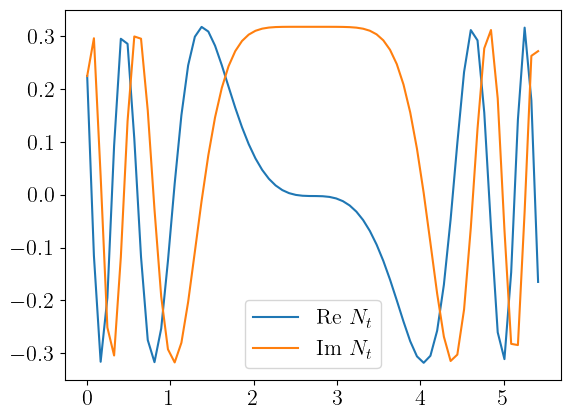

In [21]:
plt.plot(t, np.real(Nt[:, 0, 0]), label=r'Re $N_t$')
plt.plot(t, np.imag(Nt[:, 0, 0]), label=r'Im $N_t$')
plt.legend()

### Geometrical Optics in Transformed Phase Space

In [22]:
def get_branches(J):
    branch_masks = get_masks_of_const_sgn(J)
    J_desc = np.argsort(np.abs(J))[::-1]
    seeds = []
    branch_ranges = []
    for branch in branch_masks:
        branch_min, branch_max = np.min(np.argwhere(branch)), np.max(np.argwhere(branch))
        seed = J_desc[(branch_min <= J_desc) & (J_desc <= branch_max)][0]
        seeds.append(seed)
        range_back, range_forward = range(seed, max(branch_min - 1, 0), -1), range(seed, min(branch_max + 1, nt - 1), +1)
        if len(range_back) > 0:
            branch_ranges.append(range_back)
        if len(range_forward) > 0:
            branch_ranges.append(range_forward)
    return branch_masks, seeds, branch_ranges

# J = fd.grad(xs, t)
# branch_masks, seeds, branch_ranges = get_branches(J)
# print('seeds: ', seeds, 'branch_ranges: ', branch_ranges)

In [23]:
def neighbourhood(i, N, N_neighbours=1):
    '''returns slice corresponding to neighbourhood of i
        and index of i in sliced array.'''
    if i < 0 or i >= N:
        raise ValueError('index for neighbourhood is out of bounds')
    if i - N_neighbours < 0:
        return slice(min(1+2*N_neighbours, N)), i
    if i + N_neighbours >= N:
        return slice(max(0, N-(1+2*N_neighbours)), N), - (N-i)
    return slice(i - N_neighbours, i + N_neighbours + 1), N_neighbours

def nbh_ij(i, j):
    nbh2, nbh_i2 = neighbourhood(i, n2)
    nbh3, nbh_i3 = neighbourhood(j, n3)
    nbh_slice = np.s_[:, nbh2, nbh3]
    nbh_ind = np.s_[:, nbh_i2, nbh_i3]
    return nbh_slice, nbh_ind

# def init_at_seed(seed):
#     # Initialization at seed time
#     S_t0 = S[seed]
#     Zs_t0 = Zs_nbh[nbh_i0]

#     GO_t0 = GO_on_tangent_plane(0, S_t0, Zs_t0)
#     f_fit, ddf_fit = GO_t0['f_fit'], GO_t0['ddf_fit']

#     sigma_p, sigma_m = start_angles(ddf_fit)
#     l_p, l_m, s_p, s_m = get_l_and_s(f_fit, sigma_p, sigma_m)

#     return Zs_nbh, sigma_p, sigma_m, l_p, l_m, s_p, s_m


In [24]:
# def polyfit(x, y, deg):
#     dims = x.shape[-1]
#     low_degrees = list(product(*(range(deg + 1), )*dims))
#     degrees = low_degrees
#     # Alternative with less fitting coefficients if we lower the highest degree in low_degrees:
#     # high_degrees = [[],
#     #                 [(i, ) for i in range(low_deg_max, 7)],
#     #                 [(i, 0) for i in range(low_deg_max, 7)] +
#     #                  [(0, i) for i in range(low_deg_max, 5)],
#     #                 [(i, 0, 0) for i in range(low_deg_max, 7)] +
#     #                  [(0, i, 0) for i in range(low_deg_max, 5)] +
#     #                  [(0, 0, i) for i in range(low_deg_max, 3)]
#     #                 ][rho]
#     # degrees = low_degrees + high_degrees
#     monomials = np.stack([np.prod(x**d, axis=-1) for d in degrees], axis=-1)
#     coeff = np.linalg.lstsq(monomials, y, rcond=None)[0]
#     fit = lambda x: np.stack([np.prod(x**d, axis=-1) for d in degrees], axis=-1) @ coeff
#     return fit

In [25]:
class NDPolynomial():
    def __init__(self, degrees, coeff):
        self.degrees = degrees
        self.coeff = coeff
    
    def __call__(self, x):
        if len(self.degrees) > 0:
            return np.stack([np.prod(x**d, axis=-1) for d in self.degrees], axis=-1) @ self.coeff
        else:
            return np.zeros_like(x)
    
    def _diff(self, axis):
        if len(self.degrees) > 0:
            deriv_degrees = np.array([[max(d - 1, 0) if i == axis else d for i, d in enumerate(degs)] for degs in self.degrees])
            deriv_coeff = self.degrees[:, axis] * self.coeff
            ind = np.not_equal(np.isclose(deriv_coeff, 0), True)
            return NDPolynomial(deriv_degrees[ind], deriv_coeff[ind])
        else:
            return NDPolynomial([], [])

    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            deriv = deriv._diff(axis=axis)
        return deriv
    
def polyfit(x, y, deg):
    '''Returns NDPolynomial fit of x, y data.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    deg: Either `int` or `np.ndarray`.
        If deg is an `int`, deg is taken to be the highest degree in each variable
        and a monomial basis for the polynomial is generated automatically.
        Alternatively you may provide deg as an array of monomial degrees.
        For example for 3D data (M=3), you can write: `deg = np.array([(0, 0, 0), (0, 1, 0), (0, 0, 2)])`
        to get a function fit of the form f(x1, x2, x3) = a + b * x2 + c * x3**2
    '''
    dims = x.shape[-1]
    if type(deg) == int:
        degrees = np.array(list(product(*(range(deg + 1), )*dims)))
    else:
        degrees = np.array(deg)
    
    monomials = np.stack([np.prod(x**d, axis=-1) for d in degrees], axis=-1)
    coeff = np.linalg.lstsq(monomials, y, rcond=None)[0]
    ind = np.not_equal(np.isclose(coeff, 0), True)
    return NDPolynomial(degrees[ind], coeff[ind])

In [26]:
for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        # print('i, j: ', i, j)
        J_ij = np.linalg.det(gradtau_z[:, i, j, :ND])
        branch_masks, seeds, branch_ranges = get_branches(J_ij)
        
        nbh_slice, nbh_ind = nbh_ij(i, j)
        zs_nbh = zs[nbh_slice]
        # zs_nbh = zs[nbh_ij(i, j)]
        for seed, branch_range in zip(seeds, branch_ranges):
            print('branch:', branch_range, end='\r')
            for it in branch_range:
                S_t1 = S[it, i, j]
                Xs_nbh = (S_t1[:ND, :] @ zs_nbh[..., np.newaxis]).squeeze()
                Ks_t1 = (S_t1[ND:, :] @ zs[:, i, j, :, np.newaxis]).squeeze()
                gradtau_Xs_nbh = fd.grad(Xs_nbh, t, y0s, z0s, cropped_axes=[1, 2])
                gradt_Xs_t1 = gradtau_Xs_nbh[..., 0]
                J_t1 = np.linalg.det(gradtau_Xs_nbh)
                Phi_t1 = np.emath.sqrt(J_t1[it]/J_t1) # Amplitude set to 1 at tau = t1

                int_0_to_tau = cumulative_trapezoid(np_inner_product(Ks_t1, gradt_Xs_t1), t, initial=0, axis=0)
                Theta_t1 = int_0_to_tau - int_0_to_tau[it]
                mask_t1 = sgn_mask_from_seed(J_t1, (it)) # get current branch
                Field_t1 = Phi_t1*np.exp(1j*Theta_t1) * mask_t1 # only include contribution from current branch
                
                rho = ranks[it, i, j]
                a_rho = A_rhos[it, i, j, :rho, :rho]
                Lambda_rho = Lambda_rhos[it, i, j, :rho, :rho]
                Xs_t1 = Xs_nbh[nbh_ind]
                eps_t1 = Xs_t1 - Xs_t1[it]
                eps_rho = eps_t1[..., :rho]
                Ks_rho = Ks_t1[..., :rho]
                f_t1 = - ((1/2) * np_transpose(eps_rho[..., np.newaxis]) @ a_rho @ np.linalg.inv(Lambda_rho) @ eps_rho[..., np.newaxis]
                              + np_transpose(eps_rho[..., np.newaxis]) @ Ks_rho[..., np.newaxis])
                # J = np.linalg.det()
            # Zs_nbh, sigma_p, sigma_m, l_p, l_m, s_p, s_m = init_at_seed(seed)
        

In [27]:
# Alternative with less fitting coefficients if we lower the highest degree in low_degrees:
#  low_degrees = list(product(*(range(deg + 1), )*dims))
# high_degrees = [[],
#                 [(i, ) for i in range(low_deg_max, 7)],
#                 [(i, 0) for i in range(low_deg_max, 7)] +
#                  [(0, i) for i in range(low_deg_max, 5)],
#                 [(i, 0, 0) for i in range(low_deg_max, 7)] +
#                  [(0, i, 0) for i in range(low_deg_max, 5)] +
#                  [(0, 0, i) for i in range(low_deg_max, 3)]
#                 ][rho]
# degrees = np.array(low_degrees + high_degrees)

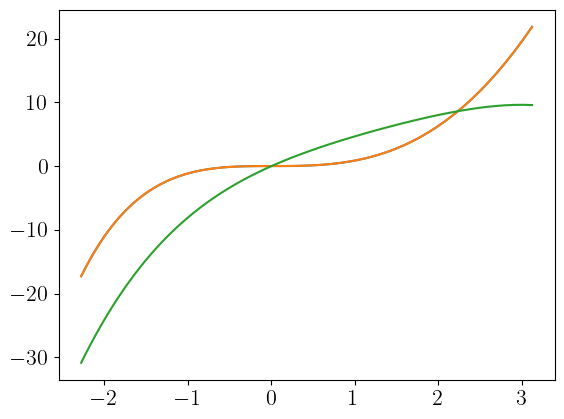

In [28]:
f_fit = polyfit(eps_rho, f_t1.squeeze(), deg=6)
plt.plot(eps_rho, f_t1.squeeze())
plt.plot(eps_rho, f_fit(eps_rho))
plt.plot(eps_rho, f_fit.deriv(axis=0, order=2)(eps_rho))